<a href="https://colab.research.google.com/github/rahulmnair1997/LabelMaster_Sales_Forecasting/blob/main/books_sarima_exog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
 
from itertools import product
from tqdm import tqdm_notebook

from sklearn.metrics import mean_squared_error

In [2]:
books = pd.read_csv('/Users/rahulnair/Desktop/Labelmaster_/Sales_Data/Books_ext_fs.csv')
#books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LabelMaster/LabelMaster Data/Books_ext.csv')
sales = books[['Year_Month','Sum of Sales']]
sales

,Year_Month,Sum of Sales
0,2008-01,282604.11
1,2008-02,262474.40
2,2008-03,326059.68
3,2008-04,215387.49
4,2008-05,499559.90
...,...,...
150,2020-07,150348.10
151,2020-08,156066.95
152,2020-09,468710.96
153,2020-10,1118446.80


In [3]:
books = books.dropna(axis = 1)
exog = books.iloc[:,2:]
exog

,"FTR Truck Loadings (000s, SA)_freight_m_trucking","FTR Active Truck Utilization (%, SA)_freight_m_trucking","Reefer Trailer Loadings (000s, SA)_freight_m_trucking","Tank Trailer Loadings (000s, SA)_freight_m_trucking","Chemicals & Allied Products (000s, SA)_freight_m_trucking",Spot TL Rates (w/o FSC)_rates_m_trucking,Total LTL (w/o FSC)_rates_m_trucking,Total LTL (w/ FSC)_rates_m_trucking,Contract TL Tank Rates (w/o FSC)_rates_m_trucking,"OEM Net Orders (U.S. / CAN, units)_indicators_m_trucking",...,BUILD FOR_All_Other,Change in Distillate Fuel Inventories_x,Intermodal Revenue Movements (IANA-ETSO)_Total_x,FTR Intermodal Competitive Index_Intermodal Competitive Index (0=Neutral)_x,U.S. Origin Intermodal Volumes_International_x,Canada Origin Intermodal Volumes_Domestic_x,"N.A. Port Activity, Total TEUs_Exports_x","West Coast Port Activity, Total TEUs_Exports_x","Gulf Coast Port Activity, Total TEUs_Exports_x","Western Canadian Port Activity, Total TEUs_Exports_x"
0,57633.608984,88.294650,3940.638792,6915.782704,3013.868684,96.932289,99.755501,114.408275,99.995901,16185.0,...,969.0,-2981.0,1156094.0,3.341993,557011.0,46969.0,1.035742e+06,428531.270000,90322.590000,70230.000000
1,57175.659828,87.998407,3927.115595,6836.939472,2975.285847,99.719858,99.755501,114.867841,100.276486,11091.0,...,1104.0,-13327.0,1088826.0,2.285576,501961.0,44924.0,1.138045e+06,478707.330000,100410.660000,86567.000000
2,56814.700553,87.790155,3922.853376,6758.129439,2941.079313,103.347853,100.488998,117.070858,99.727612,14647.0,...,1158.0,-9852.0,1082825.0,1.924076,481100.0,46727.0,1.167742e+06,500866.450000,93384.280000,80451.000000
3,56916.813852,89.639867,3978.633479,6858.428982,2906.591249,111.718085,101.589242,122.811123,99.057287,14264.0,...,931.0,-733.0,1158286.0,5.986521,528843.0,53497.0,1.156788e+06,486063.840000,101642.940000,84739.000000
4,56194.246889,89.134818,3990.692209,6804.610846,2872.185063,117.525703,101.314181,123.968232,97.828232,12060.0,...,991.0,6890.0,1184144.0,7.940801,541259.0,53653.0,1.185090e+06,490618.980000,105424.640000,89548.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,61469.059874,89.962431,4379.187334,6571.127779,2639.040651,115.128696,102.231051,113.578198,115.191063,19213.0,...,1359.0,2134.0,1526490.0,-0.192121,513074.0,57503.0,1.095134e+06,393775.832112,125276.157772,103172.000000
151,62140.797176,90.641835,4404.415547,6601.260917,2676.666422,129.107598,104.339853,115.812566,114.911925,18302.0,...,1671.0,1353.0,1575928.0,0.625716,546740.0,56478.0,1.108304e+06,389408.103791,125319.157772,93979.000000
152,62170.174317,90.587889,4381.188114,6556.745680,2600.808117,136.100117,105.898533,117.464895,115.470202,28766.0,...,1711.0,-7196.0,1617044.0,5.475578,557748.0,59269.0,1.099329e+06,386298.700253,117576.128306,103129.000000
153,62870.759335,94.367218,4436.920215,6523.796564,2593.200335,140.122763,106.265281,117.793788,115.098017,36912.0,...,2018.0,-10130.4,1705714.0,9.817290,591616.0,60708.0,1.186353e+06,410614.677268,123604.184721,105255.000000


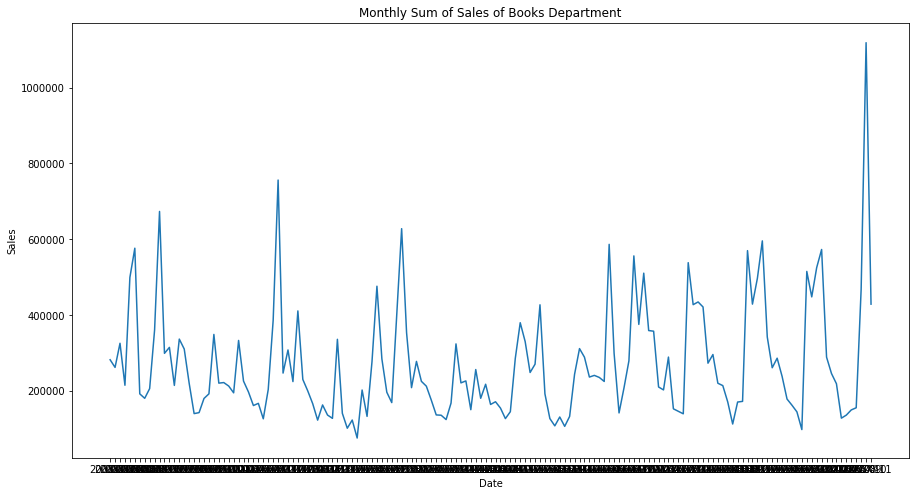

In [4]:
plt.figure(figsize=[15,8])
plt.plot(sales['Year_Month'],sales['Sum of Sales'])
plt.title('Monthly Sum of Sales of Books Department')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [5]:
ad_fuller_result = adfuller(sales['Sum of Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.5489088668534055
p-value: 0.10402307648031173


Since the p-value is greater than 0.5, we cannot reject null hypothesis and must assume that the series is not stationary.

In [6]:
sales['sales_diffed'] = sales['Sum of Sales'].diff(1)
sales

,Year_Month,Sum of Sales,sales_diffed
0,2008-01,282604.11,NaN
1,2008-02,262474.40,-20129.71
2,2008-03,326059.68,63585.28
3,2008-04,215387.49,-110672.19
4,2008-05,499559.90,284172.41
...,...,...,...
150,2020-07,150348.10,13635.82
151,2020-08,156066.95,5718.85
152,2020-09,468710.96,312644.01
153,2020-10,1118446.80,649735.84


In [7]:
ad_fuller_result = adfuller(sales['sales_diffed'][1:])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.7998057140649335
p-value: 4.659551329185685e-07


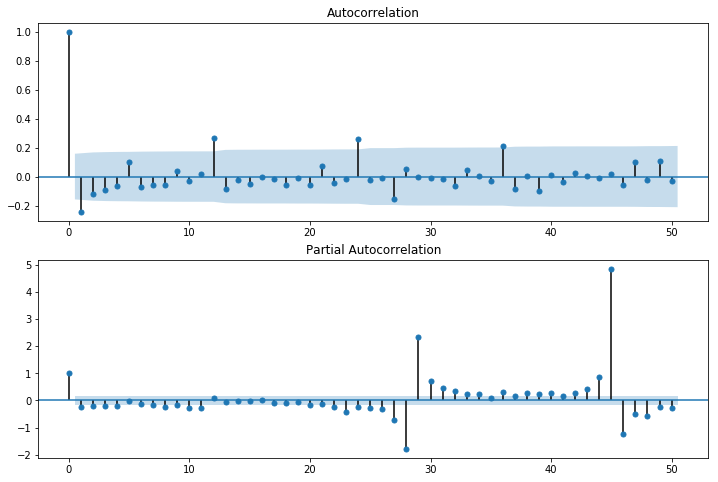

In [8]:
fig, ax = plt.subplots(2,1, figsize= (12,8))
fig = sm.graphics.tsa.plot_acf(sales['sales_diffed'][1:], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(sales['sales_diffed'][1:], lags=50, ax=ax[1])
plt.show()

# New Section

In [9]:
p = range(0,4)
d = range(1,2)
q = range(0,4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

df = pd.DataFrame()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales['Sum of Sales'],
                                            exog = exog,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}- AIC:{}'.format(param, param_seasonal, results.aic))

            combo = [(param,param_seasonal,results.aic)]
            df = df.append(combo)
            print(" ")
        except:
            continue
df.columns = ['param','param_seasonal', 'AIC']

ARIMA(0, 1, 0)x(0, 1, 0, 12)- AIC:4373.94937859835
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)- AIC:3508.395299179378
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 1, 2, 12)- AIC:3193.2451986861506
 
ARIMA(0, 1, 0)x(0, 1, 3, 12)- AIC:9472.093002961381
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)- AIC:3533.43778027099
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)- AIC:3509.8063005811964
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 2, 12)- AIC:3195.335726386519
 
ARIMA(0, 1, 0)x(1, 1, 3, 12)- AIC:9468.39570279219
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 1, 0, 12)- AIC:3216.5868874224343
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 1, 1, 12)- AIC:3217.7745460519136
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 1, 2, 12)- AIC:3195.198708601409
 
ARIMA(0, 1, 0)x(2, 1, 3, 12)- AIC:9446.970338976069
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(3, 1, 0, 12)- AIC:2904.1514932273244
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(3, 1, 1, 12)- AIC:2906.4109624230023
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(3, 1, 2, 12)- AIC:2904.0709295714337
 
ARIMA(0, 1, 0)x(3, 1, 3, 12)- AIC:9444.746765896494
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)- AIC:3789.202442384937
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)- AIC:3482.2829108789606
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 2, 12)- AIC:3168.7405327885053
 
ARIMA(0, 1, 1)x(0, 1, 3, 12)- AIC:9373.921678744982
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)- AIC:3533.506134134455
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)- AIC:3484.57462801112
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 12)- AIC:3170.8213206076025
 
ARIMA(0, 1, 1)x(1, 1, 3, 12)- AIC:9369.690189164023
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 12)- AIC:3218.718652844565
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 1, 12)- AIC:3219.95846733786
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 2, 12)- AIC:3170.6776215284785
 
ARIMA(0, 1, 1)x(2, 1, 3, 12)- AIC:9346.096016955817
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(3, 1, 0, 12)- AIC:2906.14344202988
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(3, 1, 1, 12)- AIC:2908.370706131741
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(3, 1, 2, 12)- AIC:2905.2853989262217
 
ARIMA(0, 1, 1)x(3, 1, 3, 12)- AIC:9351.755666936857
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 1, 0, 12)- AIC:3765.23678890449
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 1, 1, 12)- AIC:3456.222614559226
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(0, 1, 2, 12)- AIC:3144.6884481584025
 
ARIMA(0, 1, 2)x(0, 1, 3, 12)- AIC:9286.070049895301
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 0, 12)- AIC:3533.2265152755645
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 12)- AIC:3458.310199404855
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 2, 12)- AIC:3146.647935062812
 
ARIMA(0, 1, 2)x(1, 1, 3, 12)- AIC:9281.898478483396
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12)- AIC:3220.8767579258415
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 1, 12)- AIC:3222.103155104804
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 2, 12)- AIC:3145.6419359409715
 
ARIMA(0, 1, 2)x(2, 1, 3, 12)- AIC:9258.55040408488
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(3, 1, 0, 12)- AIC:2906.187208461316
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(3, 1, 1, 12)- AIC:2908.505589929906
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(3, 1, 2, 12)- AIC:2907.554637167458
 
ARIMA(0, 1, 2)x(3, 1, 3, 12)- AIC:9264.174865123794
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(0, 1, 0, 12)- AIC:3737.4388723831607
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(0, 1, 1, 12)- AIC:3428.0293475560898
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(0, 1, 2, 12)- AIC:3120.428245516153
 
ARIMA(0, 1, 3)x(0, 1, 3, 12)- AIC:9201.703368890836
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(1, 1, 0, 12)- AIC:3535.236504188828
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(1, 1, 1, 12)- AIC:3429.7419124249814
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(1, 1, 2, 12)- AIC:3121.8733271693595
 
ARIMA(0, 1, 3)x(1, 1, 3, 12)- AIC:9197.591715647965
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(2, 1, 0, 12)- AIC:3222.7247390260777
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(2, 1, 1, 12)- AIC:3223.7729982545293
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(2, 1, 2, 12)- AIC:3119.4361220072756
 
ARIMA(0, 1, 3)x(2, 1, 3, 12)- AIC:9174.489739059152
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(3, 1, 0, 12)- AIC:2906.042718629024
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(3, 1, 1, 12)- AIC:2908.5008664573866
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 3)x(3, 1, 2, 12)- AIC:2908.782806194152
 
ARIMA(0, 1, 3)x(3, 1, 3, 12)- AIC:9180.079011155942
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12)- AIC:3816.8142021422227
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)- AIC:3508.816880056257
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 1, 2, 12)- AIC:3194.8259025335137
 
ARIMA(1, 1, 0)x(0, 1, 3, 12)- AIC:9462.998512315215
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)- AIC:3508.7664476239715
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)- AIC:3511.198844599621
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 2, 12)- AIC:3196.8341106851562
 
ARIMA(1, 1, 0)x(1, 1, 3, 12)- AIC:9458.70710456521
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 12)- AIC:3193.3252489045694
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 12)- AIC:3194.739840816067
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 2, 12)- AIC:3196.9409452011046
 
ARIMA(1, 1, 0)x(2, 1, 3, 12)- AIC:9434.866834547307
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(3, 1, 0, 12)- AIC:2880.6828238565226
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(3, 1, 1, 12)- AIC:2882.860280176963
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(3, 1, 2, 12)- AIC:2880.124421382818
 
ARIMA(1, 1, 0)x(3, 1, 3, 12)- AIC:9440.561673470473
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)- AIC:3790.7632907358425
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)- AIC:3482.820405108548
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 2, 12)- AIC:3170.267130896302
 
ARIMA(1, 1, 1)x(0, 1, 3, 12)- AIC:9375.453849218256
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)- AIC:3508.23668549538
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)- AIC:3485.005832865695
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 12)- AIC:3169.596447492316
 
ARIMA(1, 1, 1)x(1, 1, 3, 12)- AIC:9371.2223596373
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12)- AIC:3194.023719943086
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 12)- AIC:3196.0649340995355
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 2, 12)- AIC:3171.0994698646373
 
ARIMA(1, 1, 1)x(2, 1, 3, 12)- AIC:9347.62818742909
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 0, 12)- AIC:2880.748376116732
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 1, 12)- AIC:2882.814802100854
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(3, 1, 2, 12)- AIC:2882.127340935047
 
ARIMA(1, 1, 1)x(3, 1, 3, 12)- AIC:9353.287837410131
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(0, 1, 0, 12)- AIC:3767.133086109086
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 12)- AIC:3458.208640542411
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(0, 1, 2, 12)- AIC:3146.809760242106
 
ARIMA(1, 1, 2)x(0, 1, 3, 12)- AIC:9287.993650889992
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 0, 12)- AIC:3509.9047688627998
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 12)- AIC:3460.4961936826053
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 12)- AIC:3145.5821872231986
 
ARIMA(1, 1, 2)x(1, 1, 3, 12)- AIC:9283.822079478074
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12)- AIC:3196.1333785822035
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 12)- AIC:3198.6757004085016
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 12)- AIC:3147.033412225177
 
ARIMA(1, 1, 2)x(2, 1, 3, 12)- AIC:9260.474005079568
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 0, 12)- AIC:2879.7889517692583
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 1, 12)- AIC:2881.790732298395
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(3, 1, 2, 12)- AIC:2884.3792528650797
 
ARIMA(1, 1, 2)x(3, 1, 3, 12)- AIC:9266.098466118481
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(0, 1, 0, 12)- AIC:3739.212736809999
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(0, 1, 1, 12)- AIC:3429.696122904644
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(0, 1, 2, 12)- AIC:3122.149229652018
 
ARIMA(1, 1, 3)x(0, 1, 3, 12)- AIC:9203.391106559086
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(1, 1, 0, 12)- AIC:3511.8807334933012
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(1, 1, 1, 12)- AIC:3431.5166286770905
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(1, 1, 2, 12)- AIC:3121.741884154219
 
ARIMA(1, 1, 3)x(1, 1, 3, 12)- AIC:9199.279453316214
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(2, 1, 0, 12)- AIC:3198.4529043687567
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(2, 1, 1, 12)- AIC:3200.719129336317
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(2, 1, 2, 12)- AIC:3119.4765851231955
 
ARIMA(1, 1, 3)x(2, 1, 3, 12)- AIC:9176.177476727402
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 0, 12)- AIC:2881.3617183123824
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 1, 12)- AIC:2883.3351145801453
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3)x(3, 1, 2, 12)- AIC:2885.4182003329615
 
ARIMA(1, 1, 3)x(3, 1, 3, 12)- AIC:9181.766748824191
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 1, 0, 12)- AIC:3789.973346042995
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 1, 1, 12)- AIC:3508.393048690986
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 1, 2, 12)- AIC:3196.7365623686446
 
ARIMA(2, 1, 0)x(0, 1, 3, 12)- AIC:9463.36010348064
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 0, 12)- AIC:3483.0575744774733
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 1, 12)- AIC:3485.294601693201
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 12)- AIC:3198.738146464576
 
ARIMA(2, 1, 0)x(1, 1, 3, 12)- AIC:9459.068695730637
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 12)- AIC:3168.5152312174923
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 12)- AIC:3169.9117648106485
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 2, 12)- AIC:3171.340841226558
 
ARIMA(2, 1, 0)x(2, 1, 3, 12)- AIC:9435.228425712736
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(3, 1, 0, 12)- AIC:2856.647392552512
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(3, 1, 1, 12)- AIC:2858.885834209694
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(3, 1, 2, 12)- AIC:2856.7026423242087
 
ARIMA(2, 1, 0)x(3, 1, 3, 12)- AIC:9352.514471639368
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(0, 1, 0, 12)- AIC:3791.2106760883935
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 12)- AIC:3484.614538582494
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(0, 1, 2, 12)- AIC:3171.720001079937
 
ARIMA(2, 1, 1)x(0, 1, 3, 12)- AIC:9376.38704781535
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 0, 12)- AIC:3484.62000605101
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 12)- AIC:3486.409162093231
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 12)- AIC:3171.4952272811533
 
ARIMA(2, 1, 1)x(1, 1, 3, 12)- AIC:9372.155558234394
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 12)- AIC:3170.5319411214987
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 12)- AIC:3171.6649210684627
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 12)- AIC:3171.324313314823
 
ARIMA(2, 1, 1)x(2, 1, 3, 12)- AIC:9348.561386026184
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 0, 12)- AIC:2853.4713251738785
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 1, 12)- AIC:2855.407295087916
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(3, 1, 2, 12)- AIC:2858.248339600833
 
ARIMA(2, 1, 1)x(3, 1, 3, 12)- AIC:9354.221036007222
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 0, 12)- AIC:3766.8593169367423
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 12)- AIC:3459.700764777786
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(0, 1, 2, 12)- AIC:3148.8131954364208
 
ARIMA(2, 1, 2)x(0, 1, 3, 12)- AIC:9289.651169160352
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 12)- AIC:3486.0230978867507
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 12)- AIC:3461.5397399342964
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 12)- AIC:3147.538143157533
 
ARIMA(2, 1, 2)x(1, 1, 3, 12)- AIC:9285.479597748437
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)- AIC:3171.1984054746567
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 1, 12)- AIC:3172.4218783368096
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 2, 12)- AIC:3146.9507102337557
 
ARIMA(2, 1, 2)x(2, 1, 3, 12)- AIC:9262.131523349932
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 0, 12)- AIC:2853.546773716833
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 1, 12)- AIC:2855.659190272383
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(3, 1, 2, 12)- AIC:2858.301401509724
 
ARIMA(2, 1, 2)x(3, 1, 3, 12)- AIC:9267.755984388845
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(0, 1, 0, 12)- AIC:3740.851566972662
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(0, 1, 1, 12)- AIC:3431.179598433813
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(0, 1, 2, 12)- AIC:3124.1880351953346
 
ARIMA(2, 1, 3)x(0, 1, 3, 12)- AIC:9205.34194878501
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(1, 1, 0, 12)- AIC:3487.878054137821
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(1, 1, 1, 12)- AIC:3431.573477324808
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(1, 1, 2, 12)- AIC:3123.7304738775006
 
ARIMA(2, 1, 3)x(1, 1, 3, 12)- AIC:9201.230295542146
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(2, 1, 0, 12)- AIC:3172.9863643042822
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(2, 1, 1, 12)- AIC:3172.197566240502
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(2, 1, 2, 12)- AIC:3119.353012209395
 
ARIMA(2, 1, 3)x(2, 1, 3, 12)- AIC:9178.128318953331
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 0, 12)- AIC:2856.1554647060357
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 1, 12)- AIC:2857.943758707058
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 3)x(3, 1, 2, 12)- AIC:2860.4093176400747
 
ARIMA(2, 1, 3)x(3, 1, 3, 12)- AIC:9183.717591050121
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(0, 1, 0, 12)- AIC:3765.9250494632806
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(0, 1, 1, 12)- AIC:3510.095794570822
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(0, 1, 2, 12)- AIC:3198.847111237971
 
ARIMA(3, 1, 0)x(0, 1, 3, 12)- AIC:9465.293509276475
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(1, 1, 0, 12)- AIC:3458.4238804861593
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(1, 1, 1, 12)- AIC:3460.6250500957913
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(1, 1, 2, 12)- AIC:3200.9217724830705
 
ARIMA(3, 1, 0)x(1, 1, 3, 12)- AIC:9461.00210152647
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(2, 1, 0, 12)- AIC:3145.046295535653
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(2, 1, 1, 12)- AIC:3146.364187258622
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(2, 1, 2, 12)- AIC:3147.7518641656884
 
ARIMA(3, 1, 0)x(2, 1, 3, 12)- AIC:9437.161831508567
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 1, 0, 12)- AIC:2832.4022313919954
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 1, 1, 12)- AIC:2834.613443846113
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 0)x(3, 1, 2, 12)- AIC:2832.7471833916343
 
ARIMA(3, 1, 0)x(3, 1, 3, 12)- AIC:9266.040352899701
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(0, 1, 0, 12)- AIC:3767.3365228025023
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(0, 1, 1, 12)- AIC:3486.56765363917
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(0, 1, 2, 12)- AIC:3173.7912091230974
 
ARIMA(3, 1, 1)x(0, 1, 3, 12)- AIC:9378.38704781535
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 1, 0, 12)- AIC:3460.236257021216
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 1, 1, 12)- AIC:3462.539724792771
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(1, 1, 2, 12)- AIC:3173.3449795780216
 
ARIMA(3, 1, 1)x(1, 1, 3, 12)- AIC:9374.155558234394
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(2, 1, 0, 12)- AIC:3145.476406573019
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(2, 1, 1, 12)- AIC:3147.496706279027
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(2, 1, 2, 12)- AIC:3148.4087673462873
 
ARIMA(3, 1, 1)x(2, 1, 3, 12)- AIC:9350.561386026184
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 0, 12)- AIC:2828.414186880459
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 1, 12)- AIC:2830.2060593457054
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 1)x(3, 1, 2, 12)- AIC:2835.098731973707
 
ARIMA(3, 1, 1)x(3, 1, 3, 12)- AIC:9267.815064507153
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(0, 1, 0, 12)- AIC:3769.023390563976
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(0, 1, 1, 12)- AIC:3461.5996041365484
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(0, 1, 2, 12)- AIC:3150.275682299162
 
ARIMA(3, 1, 2)x(0, 1, 3, 12)- AIC:9291.405303106638
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(1, 1, 0, 12)- AIC:3461.4927708109053
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(1, 1, 1, 12)- AIC:3463.5552944125984
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(1, 1, 2, 12)- AIC:3149.2765546900914
 
ARIMA(3, 1, 2)x(1, 1, 3, 12)- AIC:9287.233731694732
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(2, 1, 0, 12)- AIC:3148.277141503935
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(2, 1, 1, 12)- AIC:3150.81332983816
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(2, 1, 2, 12)- AIC:3151.0112447373494
 
ARIMA(3, 1, 2)x(2, 1, 3, 12)- AIC:9263.885657296212
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(3, 1, 0, 12)- AIC:2830.2422951551343
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(3, 1, 1, 12)- AIC:2831.935817441816
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 2)x(3, 1, 2, 12)- AIC:2835.157680203973
 
ARIMA(3, 1, 2)x(3, 1, 3, 12)- AIC:9269.510118335127
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(0, 1, 0, 12)- AIC:3743.0563895941978
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(0, 1, 1, 12)- AIC:3431.2652808009157
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(0, 1, 2, 12)- AIC:3123.1981505437675
 
ARIMA(3, 1, 3)x(0, 1, 3, 12)- AIC:9207.027703491223
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(1, 1, 0, 12)- AIC:3457.8312571228776
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(1, 1, 1, 12)- AIC:3433.311211200588
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(1, 1, 2, 12)- AIC:3125.147809655914
 
ARIMA(3, 1, 3)x(1, 1, 3, 12)- AIC:9202.91605024836
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(2, 1, 0, 12)- AIC:3148.5496970240015
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(2, 1, 1, 12)- AIC:3150.332905380856
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(2, 1, 2, 12)- AIC:3120.0643491106716
 
ARIMA(3, 1, 3)x(2, 1, 3, 12)- AIC:9179.814073659547
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(3, 1, 0, 12)- AIC:2832.449793333622
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(3, 1, 1, 12)- AIC:2833.2168778261635
 


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3)x(3, 1, 2, 12)- AIC:2837.3206869155783
 
ARIMA(3, 1, 3)x(3, 1, 3, 12)- AIC:9185.403345756335
 


In [10]:
df = df.sort_values('AIC').reset_index(drop= True)
df

,param,param_seasonal,AIC
0,"(3, 1, 1)","(3, 1, 0, 12)",2828.414187
1,"(3, 1, 1)","(3, 1, 1, 12)",2830.206059
2,"(3, 1, 2)","(3, 1, 0, 12)",2830.242295
3,"(3, 1, 2)","(3, 1, 1, 12)",2831.935817
4,"(3, 1, 0)","(3, 1, 0, 12)",2832.402231
...,...,...,...
251,"(1, 1, 0)","(0, 1, 3, 12)",9462.998512
252,"(2, 1, 0)","(0, 1, 3, 12)",9463.360103
253,"(3, 1, 0)","(0, 1, 3, 12)",9465.293509
254,"(0, 1, 0)","(1, 1, 3, 12)",9468.395703


The above output suggests that SARIMAX(3,1,1)(3,1,0,12) yields the lowest AIC value of 2828.563996. Therefore we should consider this to be the optimal option.

In [11]:
mod = sm.tsa.statespace.SARIMAX(sales['Sum of Sales'],
                                exog = exog,
                                order=(3, 1, 1),
                                seasonal_order=(3, 1, 0, 12))
results = mod.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                       Sum of Sales   No. Observations:                  155
Model:             SARIMAX(3, 1, 1)x(3, 1, 0, 12)   Log Likelihood               -1848.107
Date:                            Wed, 10 Mar 2021   AIC                           3852.214
Time:                                    15:52:21   BIC                           4082.768
Sample:                                         0   HQIC                          3945.902
                                            - 155                                         
Covariance Type:                              opg                                         
                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

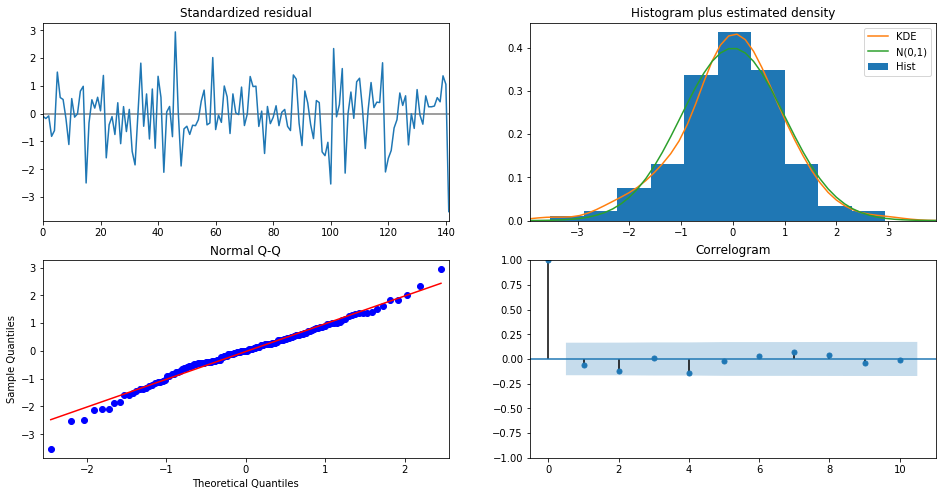

In [12]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Here we will forecast the values using the model. Can change starting point from which we need to forecast. For now we will keep starting point after 50 observations

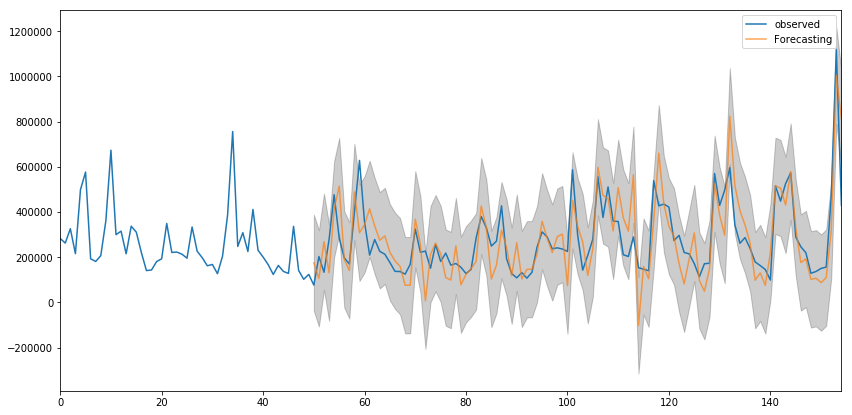

In [13]:
#Point from which prediction starts
start_point = 50
pred = results.get_prediction(start=start_point, dynamic=False)
pred_ci = pred.conf_int()
ax = sales['Sum of Sales'].plot(label='observed',)
pred.predicted_mean.plot(ax=ax, label='Forecasting', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

# Model Evaluation
### Forecast Bias
Forecast errors can be positive and negative. This means that when the average of these values is calculated, an ideal mean forecast error would be zero.
A mean forecast error value other than zero suggests a tendency of the model to over forecast (negative error) or under forecast (positive error).

In [16]:
predictions = pred.predicted_mean
predictions

50     1.751731e+05
51     1.061040e+05
52     2.685887e+05
53     1.309019e+05
54     4.123164e+05
           ...     
150    8.743925e+04
151    1.094570e+05
152    3.203617e+05
153    1.003299e+06
154    8.125360e+05
Length: 105, dtype: float64

In [24]:
predictions = pred.predicted_mean
actual = sales['Sum of Sales'][start_point:]
error = actual - predictions
bias = sum(error)/len(error)
print('Bias: %f' %bias)

Bias: 196.807219


Here we have a negative bias, meaning we over forecast. Lets look into other metrics for model evaulation

### MAE (Mean Absolute Error)
The mean absolute error, or MAE, is calculated as the average of the forecast error values, where all of the forecast error values are forced to be positive.

In [18]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
MAE = mean_absolute_error(actual,predictions)
print(f'Mean Absolute Error: {MAE}')

Mean Absolute Error: 84610.81926691142


### MSE (Mean Squared Error)
The mean squared error, or MSE, is calculated as the average of the squared forecast error values. Squaring the forecast error values forces them to be positive; it also has the effect of putting more weight on large errors.

In [19]:
MSE = mean_squared_error(predictions,actual)
print(f'Mean Squared Error: {MSE}')

Mean Squared Error: 12545958954.831171


In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


print(mean_absolute_percentage_error(actual, predictions))

0.35601071356320146


### RMSE (Root Mean Squared Error)
The mean squared error described above is in the squared units of the predictions.

It can be transformed back into the original units of the predictions by taking the square root of the mean squared error score. This is called the root mean squared error, or RMSE.

In [26]:
from math import sqrt
RMSE = sqrt(MSE)
print(f'Root Mean Squared Error: {RMSE}')

Root Mean Squared Error: 112008.74383198014
